# Activation Maximization on VGGNet

## Dense Layer Visualizations

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear' and compare what happens if we dont do this at the end.

In [1]:
from keras.applications import VGG19 as VGG16
from vis.utils import utils
from keras import activations

# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Using TensorFlow backend.
/home/yimengzh/miniconda2/envs/tf15/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Visualizing a specific output category

Lets try visualizing a specific output category. We will pick `ouzel` which corresponds to imagenet category `20`

In [2]:
from vis.visualization import visualize_activation

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

Hmm, that sort of looks like a bird. Lets see if we can get better results with more iterations. This time, lets see the verbose output during the optimization process.

We can see that the loss appears to be converging. So more iterations definitely seem to give better output. One way to get crisper results is to use `Jitter` input_modifier. As the name suggests, `Jitter` moves pixels around in the image. Lets try this out.

In [3]:
from vis.input_modifiers import Jitter

Look at that! Not only has the conv net captured what it means to be an ouzel, but it also seems to encode for different orientations and scales, a further proof of rotational and scale invariance. 

Lets try this for a bunch of other random categories. This will take a while. Go grab a nice cup of coffee and prepare to be amused :)

In [4]:
import numpy as np
plt.rcParams['figure.figsize'] = (50, 50)

Some of them make sense if you stare at ot for a while. There are ways of improving this. We will cover some ideas for this in the next section. You can come back here and try those out as an exercise.

## Visualizing Conv filters

In a CNN, each Conv layer has several learned *template matching* filters that maximize their output when a similar 
template pattern is found in the input image. First Conv layer is easy to interpret; simply visualize the weights as an image. To see what the Conv layer is doing, a simple option is to apply the filter over raw input pixels. 
Subsequent Conv filters operate over the outputs of previous Conv filters (which indicate the presence or absence 
of some templates), making them hard to interpret.

One way of interpreting them is to generate an input image that maximizes the filter output. This allows us to generate an input that activates the filter.

Lets start by visualizing the second conv layer of vggnet (named as 'block1_conv2'). Here is the VGG16 model for reference.

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
from vis.visualization import get_num_filters

They mostly seem to match for specific color and directional patterns. Lets try a bunch of other layers.
We will randomly visualize 10 filters within various layers.

In [7]:
from tang_jcompneuro import dir_dictionary
import os.path
from skimage.io import imsave

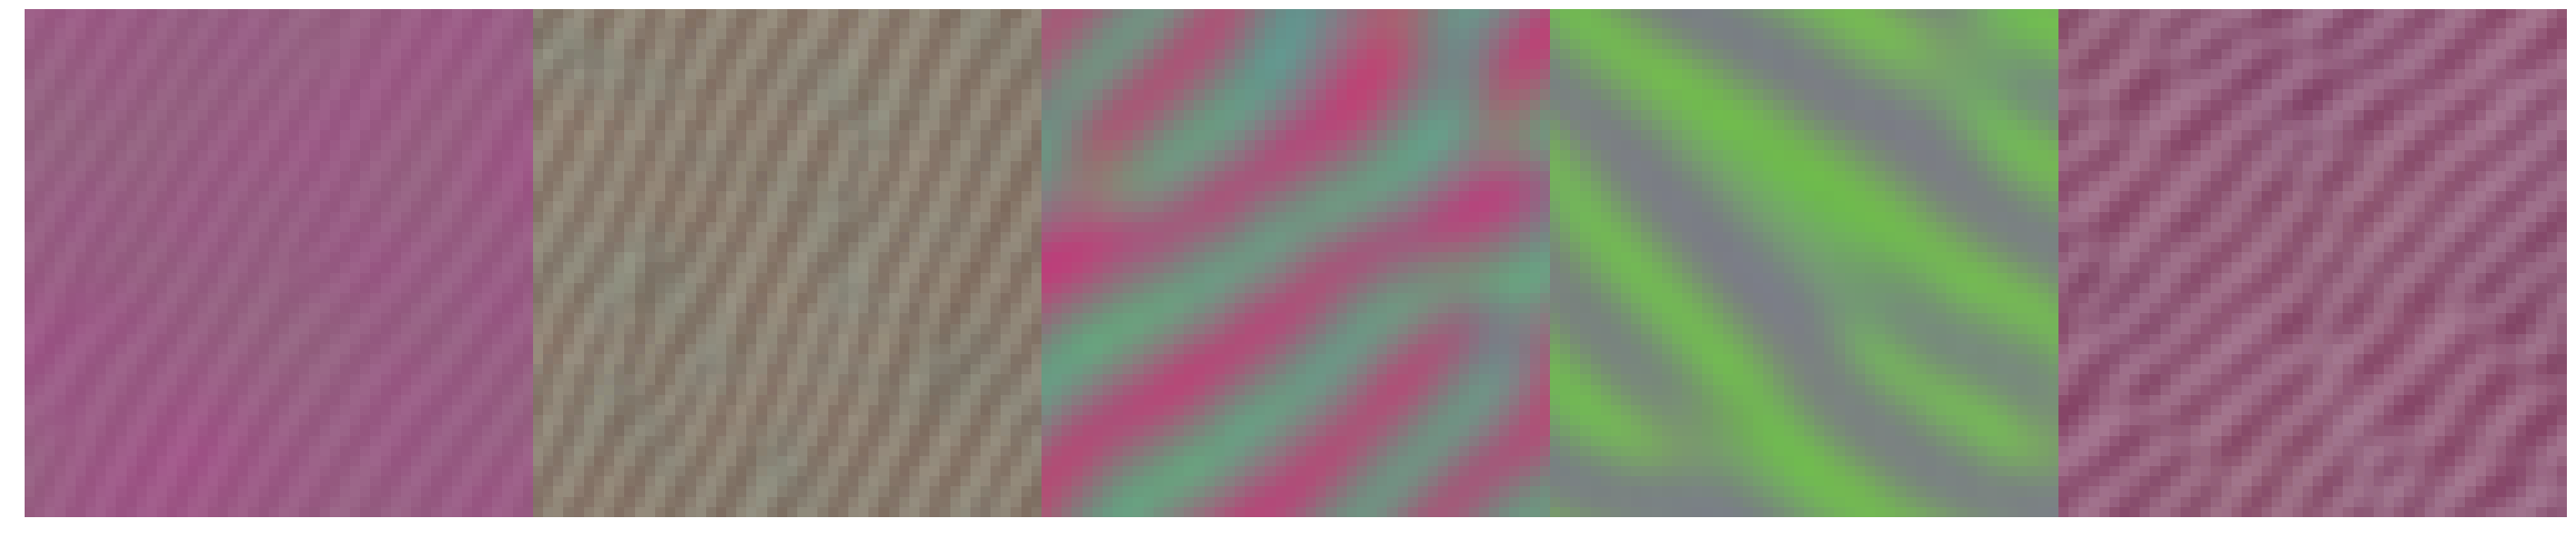

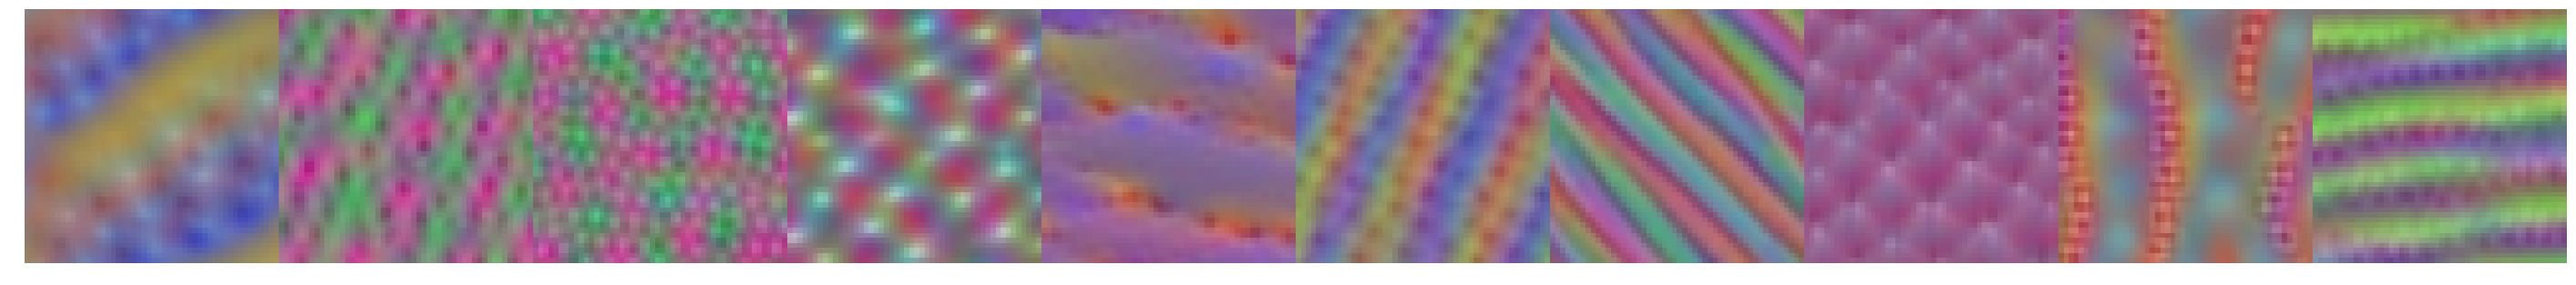

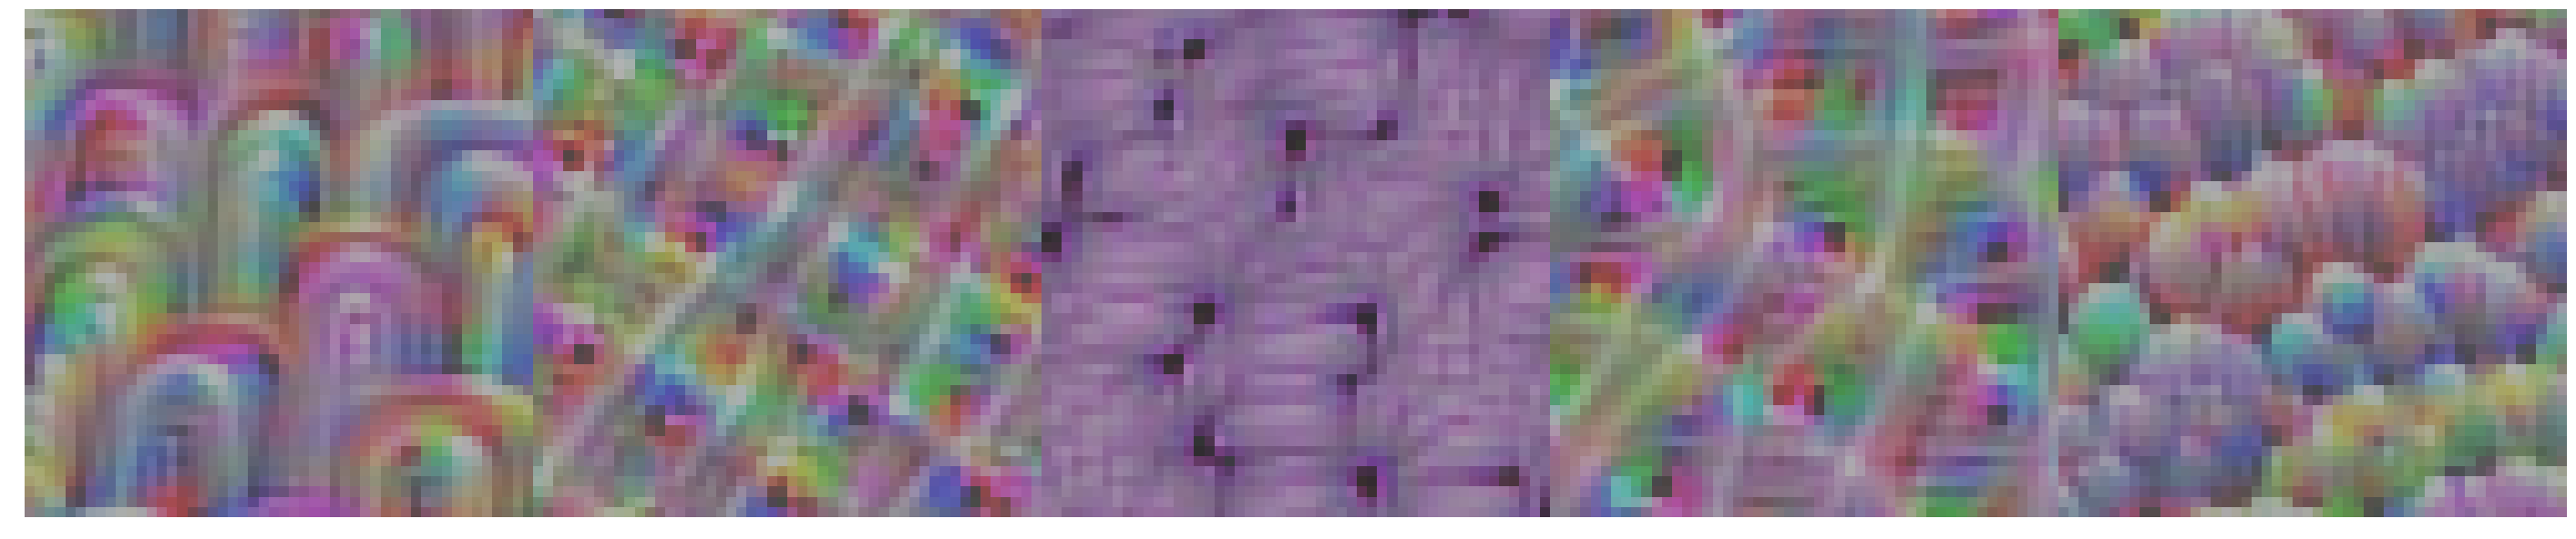

In [8]:
selected_indices = []
np.random.seed(42)  # try some good seed

cherrypick_dict = {
    'block2_conv1': (0,4,5,7,9),
    'block3_conv1': range(10),
    'block4_conv1': (1,3,5,6,7)
}

for layer_name in ['block2_conv1', 'block3_conv1',
                   'block4_conv1',]:
    layer_idx = utils.find_layer_idx(model, layer_name)
    cherry_this = cherrypick_dict[layer_name]

    # Visualize all filters in this layer.
    filters = np.random.permutation(get_num_filters(model.layers[layer_idx]))[:10]
    selected_indices.append(filters)

    # Generate input image for each filter.
    vis_images = []
    for img_idx, idx in enumerate(filters):
        img = visualize_activation(model, layer_idx, filter_indices=idx,
                                   tv_weight=1,lp_norm_weight=1)
        assert img.shape == (224,224,3)
        img = img[112-25:112+25,112-25:112+25]

        # Utility to overlay text on image.
        # img = utils.draw_text(img, 'Filter {}'.format(idx))
        if img_idx in cherry_this:
            vis_images.append(img)

    # Generate stitched image palette with 5 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images, cols=10,margin=0)
    save_dir = os.path.join(dir_dictionary['plots'], 'main', 'vgg_vis')
    os.makedirs(save_dir, exist_ok=True)
    # save.
    imsave(os.path.join(save_dir, layer_name + '.png'), stitched)
    
    plt.close('all')
    plt.figure()
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()

We can see how filters evolved to look for simple -> complex abstract patterns.

We also notice that some of the filters in `block5_conv3` (the last one) failed to converge.  This is usually because regularization losses (total variation and LP norm) are overtaking activation maximization loss (set verbose=True to observe). There are a couple of options to make this work better,

- Different regularization weights.
- Increase number of iterations.
- Add `Jitter` input_modifier.
- Try with 0 regularization weights, generate a converged image and use that as `seed_input` with regularization enabled.

I will show a subset of these ideas here. Lets start by adidng Jitter and disabling total variation.

We can see how previously unconverged filters show something this time. Lets take a specific output from here and use it as a `seed_input` with total_variation enabled this time.

And that, folks, is how we roll :)
This trick works pretty well to get those stubborn filters to converge.